## Synopsis
LendingClub is a US peer-to-peer lending company, which operates an online lending platform that enables borrowers to obtain a loan, and investors to purchase notes backed by payments made on loans. Lending Club is the world's largest peer-to-peer lending platform. The company claims that $15.98 billion in loans had been originated through its platform up to December 31, 2015.

To find good borrowers is key for the investors in LendingClub to make profit. How to find a good borrowers? In other word, how to predict the loan status according to the information of the loan applicants? A predictive model of loan status can help the investors to make a wise decision for the loan applicants and decrease the risk of bad loans.

In this report, we attempt to predict the risk of the loan being default based on the past loan data. We obtained data from LendingClub’s website(https://www.lendingclub.com/info/download-data.action). We also get external data resource for the unemployment rate in United States by zip codes from Kaggle. The assumption is if a borrowers from a zip code area with high unemployment rate he is more likely to have a bad loan. The investors can make a judgement according to the zip code of the borrowers for they correlate with Unemployment rate.

We use loan data from year 2015 and perform data wrangling, explanatory data analysis and statistical hypothesis testing. We also split the data set into training and test data sets and apply tree based methods to build predictive models for the loan status. We found that, among multiple machine learning algorithms that we tried, Gradient boosting method provided a reasonable trade-off performance, and a higher return than the naive loan picking strategy can be achieved.

In [1]:
import sys
from numpy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
%matplotlib inline

In [2]:
# read lending club stat file
df = pd.read_csv("LoanStats3d.csv",skiprows=1,low_memory=False)
df.shape

(421097, 137)

The blank columns wouldn't provide any information. The post loan variables and hardship variables are not suitable for the predictive model building. So we delete these variables.

In [3]:
blank_columns = df.columns[df.isnull().all()].tolist()
blank_columns

['member_id',
 'url',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_il_6m',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [4]:
# drop blank columns
df = df.drop(['id','member_id', 'url','revol_bal_joint','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
 'sec_app_open_acc','sec_app_revol_util','sec_app_open_il_6m','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog'], axis = 1)

# drop post loan variables
df = df.drop(['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
              'grade', 'sub_grade','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d',
              'payment_plan_start_date','issue_d',"funded_amnt_inv","loan_amnt",'num_tl_120dpd_2m','num_tl_30dpd'], axis = 1)
df = df.drop(['term','int_rate','installment'], axis = 1)

# drop hardship variables
df = df.drop(['hardship_flag','hardship_type','hardship_reason', 'hardship_status','hardship_start_date',
             'hardship_end_date','hardship_loan_status', 'hardship_amount','hardship_length','hardship_dpd',
              'hardship_payoff_balance_amount','hardship_last_payment_amount'], axis = 1)

## Object variable wrangling
### a. Target variable: How many class of loan status are there?

The target variable in the project is loan status. There are 7 types of loan status. Among them 'Current', 'Fully Paid' and 'In grace Peroid' mean that the lenders are paying the loan on time or have already paid the loan off. So these three status are called 'good loan'. And the rest four status mean the lenders have delayed the payment more than 15 days or even have no ability to make any payment at all. These four status are called 'bad loan'.

In [5]:
obj_df = df.select_dtypes(include=['object']).copy()
pd.unique(obj_df['loan_status'].values.ravel())

array(['Current', 'Fully Paid', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', nan], dtype=object)

In [6]:
# classified loan_status to "good loan" and "bad loan"
status_dict = {'loan_status': {'Current':'good loan', 'Fully Paid':'good loan', 'In Grace Period':'good loan', 'Charged Off':'bad loan', 'Late (16-30 days)':'bad loan',
                'Late (31-120 days)':'bad loan', 'Default':'bad loan'}}
obj_df.replace(status_dict, inplace=True)
obj_df.shape

(421097, 16)

In [7]:
# drop the variables which have more than 90% missing values
obj_df = obj_df.drop(['verification_status_joint', 'desc'], axis=1) 

### b. Data cleaning for other object variables

'title' is replicated in 'purpose' so we will drop them.

In [8]:
obj_df['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'house', 'medical', 'other', 'car',
       'small_business', 'vacation', 'moving', 'renewable_energy',
       'wedding', 'educational', nan], dtype=object)

In [9]:
obj_df['title'].unique()

array(['Debt consolidation', 'Credit card refinancing', 'Home improvement',
       nan, 'Major purchase', 'Home buying', 'Medical expenses', 'Other',
       'Car financing', 'Business', 'Vacation', 'Moving and relocation',
       'Green loan', 'odymeds', 'SAVE', 'Learning and training', 'new day',
       'Trying to come back to reality!', 'considerate',
       'Paying off higher interest cards & auto',
       'Simple Loan Until Contract Is Completed',
       'Prescription Drug and Medical Costs', 'Pay off Lowes Card',
       'new kitchen for momma!', 'DebtC',
       'New Baby and New House (CC Consolidate)',
       'Credit Card/Auto Repair', 'Student Loan'], dtype=object)

In [10]:
obj_df = obj_df.drop('title', axis=1)

In [11]:
#convert 'obj_df.revol_util' to numeric variable
obj_df.revol_util = pd.Series(obj_df.revol_util).str.replace('%', '').astype(float)

In [12]:
# convert emp_length to numeric variable
obj_df.emp_length.value_counts()

10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
n/a           23817
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64

In [13]:
obj_df.replace('n/a', np.nan,inplace=True)
obj_df.emp_length.fillna(value=0,inplace=True)
obj_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
obj_df['emp_length'] = obj_df['emp_length'].astype(float)

### c. Feature  engineering

### emp_title
This variable has 120813 categories and we can choose the top ten employment tiltle and create 10 dummy variables so it can be used in model building.

In [14]:
obj_df.emp_title.unique().shape

(120813,)

In [15]:
obj_df['emp_title'].str.lower().value_counts().head(10)

teacher             9956
manager             8958
owner               6101
registered nurse    4443
supervisor          4080
driver              3863
sales               3759
rn                  3545
office manager      2826
project manager     2734
Name: emp_title, dtype: int64

In [16]:
# 'rn' should be the same as 'registered nurse'
obj_df['emp_title'] = obj_df['emp_title'].str.lower().replace('rn', 'registered nurse')

In [17]:
# select top ten employment title
cats = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
obj_df.loc[~ (obj_df['emp_title'].isin(cats)), 'emp_title'] = 'other'
obj_df.emp_title.value_counts()

other               368270
teacher               9956
manager               8958
registered nurse      7988
owner                 6101
supervisor            4080
driver                3863
sales                 3759
office manager        2826
project manager       2734
general manager       2562
Name: emp_title, dtype: int64

### Zip code and state
These two variables can't be used directly for the analysis of loan status. But if they combined with the local unemployment rates in US they will be useful for the analysis.

In [18]:
obj_df['zip_code'] = obj_df['zip_code'].str.replace('xx', '00')
unemp_zip = pd.read_csv('unemploy_zip.csv')
print(unemp_zip.shape)
unemp_zip.head(3)

(855, 3)


,state,zip_code,Rate
0,AK,99500,8.48
1,AK,99600,8.69
2,AK,99700,8.41


In [19]:
# concatenate the two files
obj_df['zip_code'] = obj_df['zip_code'].astype('float')
obj_df = obj_df.rename(columns={'addr_state':'state'})
unemp_zip['zip_code'] = unemp_zip['zip_code'].astype('float')
obj_df1 = pd.merge(obj_df, unemp_zip, on=['state','zip_code'], how='left')
obj_df1.Rate.count()

387468

The total observations for the data set are 421095. And there are 387468 observations for the 'Rate' variable. The reason is that there are 855 zip_unemployment rates in unemp_zip files while there are 915 zip codes in lending club dataset. So there would have missing values for the unemployment rate when these two files are merged together.

## Numerical variables wrangling

In [20]:
num_df = df.select_dtypes(include=['float']).copy()

In [21]:
# find the numerical variables which have more than 10% of outliers
for col in num_df.columns:
    Q1 = num_df[col].quantile(0.25)
    Q3 = num_df[col].quantile(0.75)
    IQR = Q3 - Q1
    out_liers_number = ((num_df[col] < (Q1 - 3 * IQR)) | (num_df[col] > (Q3 + 3 * IQR))).sum()
    count = df[col].count()
    if out_liers_number > (0.1 * count):
        print ("Column {} has {} outliers".format(col, out_liers_number)) 

#from scipy import stats
#df[(np.abs(stats.zscore(df)) > 3).all(axis=1)]

Column delinq_2yrs has 87087 outliers
Column pub_rec has 74415 outliers
Column tot_coll_amt has 66407 outliers
Column num_accts_ever_120_pd has 102993 outliers
Column pub_rec_bankruptcies has 50916 outliers


In [22]:
# concat object variable files and numeric variable file
obj_df1['zip_code'] = obj_df1['zip_code'].astype('object')
df1 = pd.concat([obj_df1, num_df], axis=1 )

## Explanatory Data Analysis

#### How many good loans and bad loans are there?

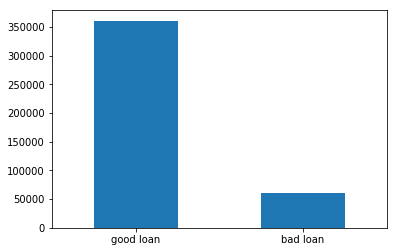

In [23]:
_ = df1['loan_status'].value_counts().plot(kind='bar')
_.set_xticklabels(['good loan', 'bad loan'], rotation=0)

Among all the loans about 20% is bad loans and 80% is good loans.

#### The loan amount and employment title

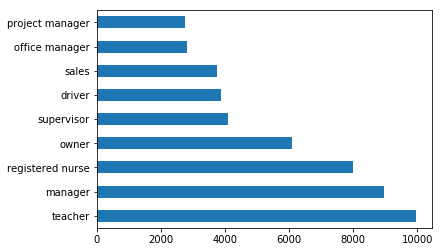

In [24]:
df1['emp_title'].value_counts()[1:10].plot(kind='barh')

Teacher is the occupation which has the largest number of loans. Manager and registered nurse rank the second and third in the number of loans.

#### The bad loan percentage for different occupations 

In [25]:
# create a function to caculate good loan/bad loan for different variables and their percentages
def calculation(col, col_cats):
    df2=df1[df1[col].isin(col_cats)][['loan_status', col]]
    good_loan_data = df2[df2.loan_status == 'good loan']
    bad_loan_data = df2[df2.loan_status == 'bad loan']

    good_loan = good_loan_data.groupby(col).size().sort_values(ascending=False).values
    bad_loan = bad_loan_data.groupby(col).size().sort_values(ascending=False).values

    totals = good_loan + bad_loan
    data1_percentages = (good_loan/totals)*100 
    data2_percentages = (bad_loan/totals)*100
    return good_loan,bad_loan,data1_percentages,data2_percentages


In [26]:
# create plot function
def plot(xticks, col, col_cats):
    
    good_loan,bad_loan,data1_percentages,data2_percentages = calculation(col, col_cats)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # plot chart for count of loan status by col
    ax1.bar(range(len(good_loan)), good_loan, label='Good_loan', alpha=0.7, color='b')
    ax1.bar(range(len(bad_loan)), bad_loan, bottom=good_loan, label='Bad_loan', alpha=0.7, color='r')
    plt.sca(ax1)
    plt.xticks(xticks, col_cats, rotation=45, ha='right', size=17)
    ax1.set_ylabel("Count")
    ax1.set_xlabel("")
    ax1.set_title("Count of loan status by {}".format(col),fontsize=17)
    plt.legend(loc='upper right')

    # plot chart for percentage of loan status by col
    ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.7, color='b')
    ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.7, color='r')
    plt.sca(ax2)
    plt.xticks(xticks, col_cats, rotation=45, ha='right',size=17)
    ax2.set_ylabel("Percentage")
    ax2.set_xlabel("")
    ax2.set_title("% of loan status by {}".format(col),fontsize=17)

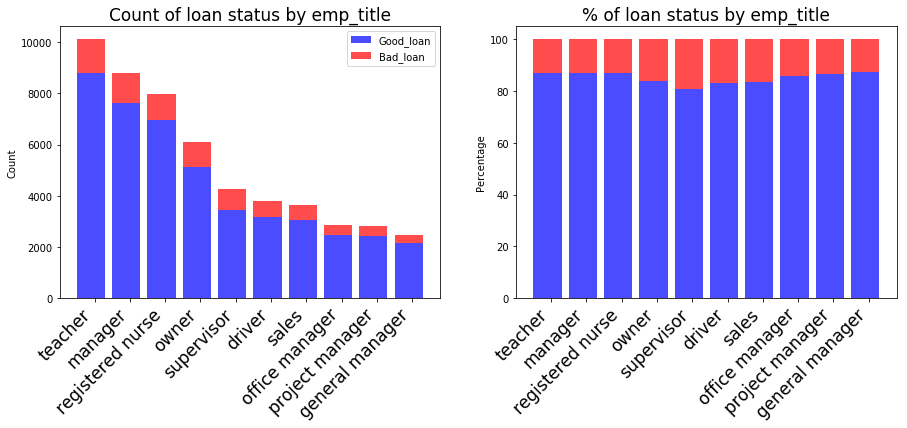

In [27]:
xticks = [0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]
emp_title_categories = ['teacher','manager','registered nurse', 'owner','supervisor','driver','sales','office manager',
        'project manager','general manager']
plot(xticks,'emp_title', emp_title_categories)

Although teachers have largest number of loans they have relatively low bad loan percentage. And manager and registered nurse also have low bad loan ratio.

#### The relationship between loan status and home ownership

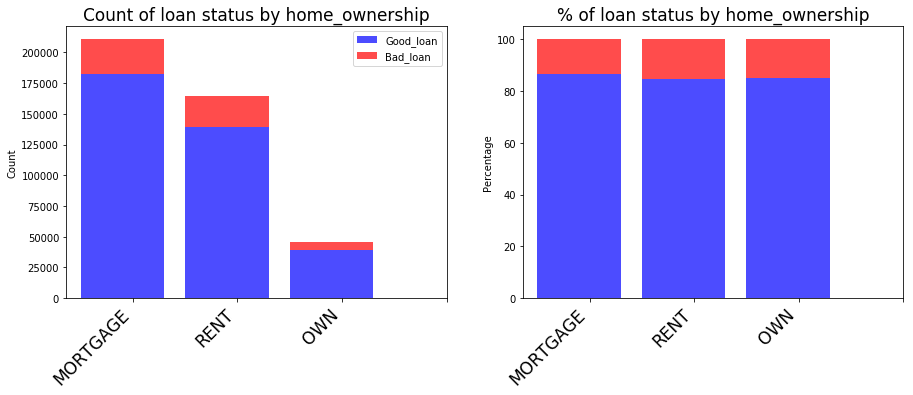

In [28]:
xticks = [0.1, 1.1, 2.1, 3.1]
home_ownership_categories = ['MORTGAGE','RENT','OWN']
plot(xticks,'home_ownership', home_ownership_categories)

The people who have mortgage have largest number of loans while their bad loan percentage is relatively low compare to the renters/home owners.

#### The relationship of zip code, unemployment rate and bad loan percentage

What is the mean unemployment rate in zip codes for bad/good loans?

In [29]:
data = df1.loc[df1.loan_status == 'bad loan', ['state', 'zip_code', 'Rate', 'loan_status']].groupby(['state', 'zip_code']).mean()
data = data.reset_index()
data.sort_values('Rate', ascending=False, inplace=True)
data.head()

,state,zip_code,Rate
84,CA,92200.0,15.37
302,KY,41600.0,12.05
904,WV,24800.0,11.92
57,AZ,86500.0,11.55
438,MS,38700.0,11.31


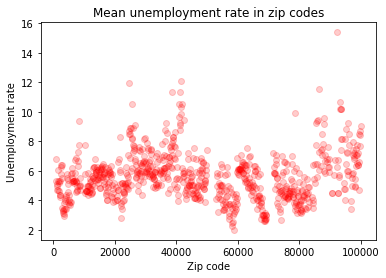

In [30]:
# mean unemployment rate in zip codes for bad/good loans
plt.scatter(data['zip_code'], data['Rate'], alpha=0.2, c='red')
plt.xlabel('Zip code')
plt.ylabel('Unemployment rate')
plt.title('Mean unemployment rate in zip codes')

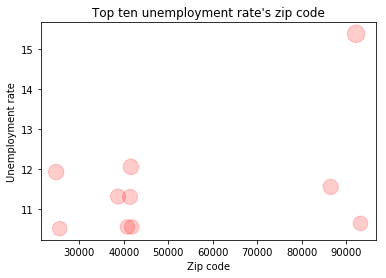

In [31]:
# top ten mean unemployment rate in zip codes for bad/good loans
plt.scatter(data['zip_code'].values[:10], data['Rate'].values[:10], 
            alpha=0.2, s=20*data['Rate'].values[:10],c='red')
plt.xlabel('Zip code')
plt.ylabel('Unemployment rate')
plt.title("Top ten unemployment rate's zip code")

The top ten unemployment rates locate in three zip codes area(20000, 40000, 90000).States CA and AZ's zip codes are around 90000, KY is around 40000, WV and MS are around 20000.

Will the loan lenders in the five states(CA, AZ, KY, WV and MS) which have high unemployment rates also have high bad loan percentage?

In [32]:
# caculation of bad loan percentage in zip code
def bad_loan_perc_zip(DF):
    new1 = DF.loc[DF.loan_status == 'good loan', ['state', 'zip_code', 'Rate', 'loan_status']]
    new2 = DF.loc[DF.loan_status == 'bad loan', ['state', 'zip_code', 'Rate', 'loan_status']]

    a = pd.DataFrame(new1.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    a = a.reset_index()

    b = pd.DataFrame(new2.groupby(['state', 'zip_code', 'Rate'])['loan_status'].size())
    b = b.reset_index()

    total = pd.merge(a, b, on=['state','zip_code'], how='left').drop('Rate_y', axis=1)
    total.fillna(0, inplace=True)
    total['bad_loan_perc'] = (total['loan_status_y']/(total['loan_status_x'] + total['loan_status_y'])) * 100
    return total

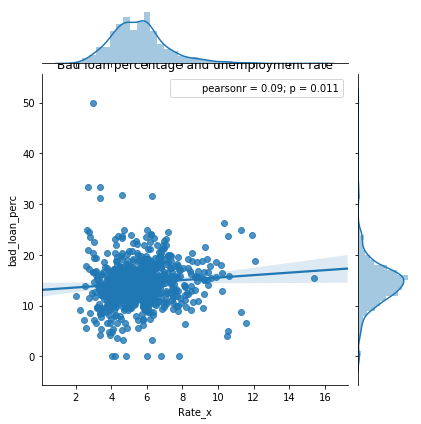

In [33]:
# plot the bad loan percentage with unemployment rate in the same zip code area
import seaborn as sns
total = bad_loan_perc_zip(df1)
sns.jointplot('Rate_x', 'bad_loan_perc', data=total, kind='reg')
plt.title('Bad loan percentage and unemployment rate')

From the above plot we can see that the higher the unemployment rate is the higher the bad loan percentage. So we should pay attention to the loan applicants from the five states(CA, AZ, KY, WV and MS) which have high unemployment rates.

What are the relationships of the mean unemployment rate for people without loan, in good loan status and in bad loan status in the same zip code area?

In [38]:
# get unemployment rate of unloanded population
new = unemp_zip[['Rate']]  
new['loan_status'] = ['rejected population'] * 855

# get enemployment rate of good loan lenders and bad loan lenders
new1 = df1.loc[df1.loan_status == 'good loan', ['Rate', 'loan_status']]
new2 = df1.loc[df1.loan_status == 'bad loan', ['Rate', 'loan_status']]

# concatenate the three files 
frames = [new, new1, new2]
new_total = pd.concat(frames)
new_total.shape

C:\Users\yepeng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(421950, 2)

In [35]:
print("Rejected population' mean unemployment rate: " + str(new.Rate.mean()))
print("Good loan lenders' mean unemployment rate: " + str(new1.Rate.mean()))
print("Bad loan lenders' mean unemployment rate: " + str(new2.Rate.mean()))

Rejected population' mean unemployment rate: 5.523099415204683
Good loan lenders' mean unemployment rate: 5.4941326246224715
Bad loan lenders' mean unemployment rate: 5.554777603913014


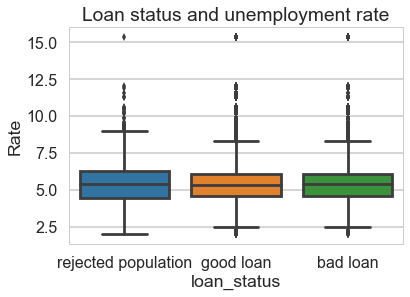

In [39]:
sns.set_style("whitegrid")
sns.set_context("poster")
_ = sns.boxplot(x='loan_status', y='Rate', data=new_total)
plt.title('Loan status and unemployment rate')

From the above figure we can see the mean unemployment rate for good loan lenders is lower than that of unloaded population and bad loan lenders. The mean calculation shows the mean unemployment rate for unloaded population is lower than that of bad loan lenders.

In other words, people that are accepted for a loan and pay back a loan on time typically more easily  employed than the rest of the population. While people that are accepted for a loan and don't pay back a loan typically more likely to be unemployed than the rest of the population.

#### The relationship of employment length and bad loan percentage

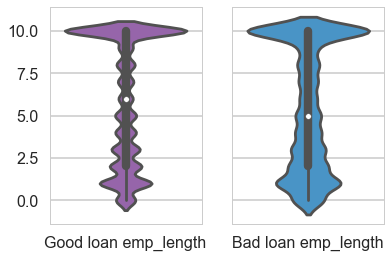

In [40]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
g_loan.columns = ["Good loan emp_length"]

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b_loan.columns = ["Bad loan emp_length"]

fig, axs = plt.subplots(ncols=2, sharey=True)
sns.violinplot(data=g_loan, ax=axs[0], color='#9b59b6')
sns.violinplot(data=b_loan, ax=axs[1], color='#3498db')

## Statistical Analysis

### Numeric variables correlation analysis

In [34]:
# calculate correlation coefficient of the numeric variables
num_df = df.select_dtypes(include=['float']).copy()
cor = num_df.corr()

# find the highly correlated variables
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = pd.DataFrame(cor.stack())
cor.rename(columns = {0 :'correlation'}, inplace = True)
cor_75 = cor[(cor.correlation > 0.75) | (cor.correlation < -0.75)]
cor_75 = cor_75.reset_index()
cor_75.rename(columns={'level_0':'variable_0', 'level_1':'variable_1'}, inplace=True)
cor_75.head()

,variable_0,variable_1,correlation
0,open_il_24m,open_il_12m,0.760552
1,open_rv_24m,open_rv_12m,0.767262
2,total_rev_hi_lim,revol_bal,0.833423
3,acc_open_past_24mths,open_rv_24m,0.842395
4,avg_cur_bal,tot_cur_bal,0.834840


In [35]:
#slice the first ten correlated pair of variables
a = cor_75.variable_0.values[:10]
b = cor_75.variable_1.values[:10]
c = list(a) + list(b)
c = set(c)
print(c)

{'tot_cur_bal', 'num_bc_sats', 'open_rv_12m', 'mths_since_recent_revol_delinq', 'avg_cur_bal', 'num_actv_rev_tl', 'acc_open_past_24mths', 'num_actv_bc_tl', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'open_rv_24m', 'open_il_12m', 'revol_bal', 'total_rev_hi_lim', 'open_il_24m'}


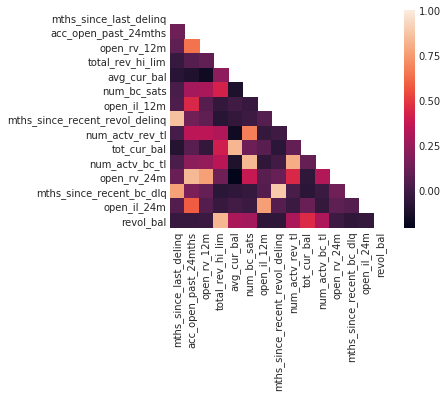

In [36]:
# correlation hotmap for the selected variables
high_cor = num_df[['mths_since_last_delinq', 'acc_open_past_24mths', 'open_rv_12m', 'total_rev_hi_lim',
                   'avg_cur_bal', 'num_bc_sats', 'open_il_12m', 'mths_since_recent_revol_delinq', 
                   'num_actv_rev_tl', 'tot_cur_bal', 'num_actv_bc_tl', 'open_rv_24m', 
                   'mths_since_recent_bc_dlq', 'open_il_24m', 'revol_bal']]
high_corr = high_cor.corr()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(high_corr, mask=mask, vmax=1, square=True)

### Chi squrare test for the loan status and employment title

 It tests whether the distribution of sample categorical data matches an expected distribution.

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'emp_title' are independent.

H 1  : In the population, variable'loan_status' and variable 'emp_title' are dependent. 

In [37]:
def create_table(DF, col, colcats): 
    df = DF[DF[col].isin(colcats)][[ 'loan_status', col]]
    Con_Table = pd.crosstab(df.loan_status, df[col], margins=True) 
    Con_Table.columns =  colcats +['row_totals']
    Con_Table.index = ['good','bad', 'col_totals']
    return Con_Table, df 

In [38]:
Con_Table, df = create_table(df1, 'emp_title', emp_title_categories)
Con_Table

,teacher,manager,registered nurse,owner,supervisor,driver,sales,office manager,project manager,general manager,row_totals
good,817,403,1319,379,987,313,1044,610,642,1162,7676
bad,3046,2159,7639,2447,5114,2421,6944,3149,3438,8794,45151
col_totals,3863,2562,8958,2826,6101,2734,7988,3759,4080,9956,52827


In [39]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:10]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:10]) / 52827

expected = pd.DataFrame(expected)

expected.columns = emp_title_categories
expected.index = ['good','bad']

In [40]:
import scipy.stats as stats
def chi_square_test(freedom):
    # chi square statistics
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

    print('chi_squared_stat: ' + str(chi_squared_stat))

    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = freedom)  

    print("Critical value: " + str(crit))

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                df=freedom)
    print("P value: " + str(p_value))

chi_square_test(12)

chi_squared_stat: 269.3493768308436
Critical value: 21.0260698175
P value: 0.0


Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'emp_title are dependent at alpha = 0.05 level. In other words loan status dependend on what kind of employment title of the borrowers.

### Chi square test for loan status and home ownership

Hypothesis

H 0  : In the population, variable'loan_status' and variable 'home_ownership' are independent.

H 1  : In the population, variable'loan_status' and variable 'home_ownership' are dependent.

In [41]:
Con_Table, df = create_table(df1, 'home_ownership', home_ownership_categories)
Con_Table

,MORTGAGE,RENT,OWN,row_totals
good,25314,6778,28354,60446
bad,182369,38988,139290,360647
col_totals,207683,45766,167644,421093


In [42]:
# get observed value and expected value
observed = Con_Table.iloc[0:2, 0:3]

expected =  np.outer(Con_Table["row_totals"][0:2],
                     Con_Table.iloc[2, 0:3]) / 421093

expected = pd.DataFrame(expected)

expected.columns = home_ownership_categories
expected.index = ['good','bad']

In [43]:
chi_square_test(5)

chi_squared_stat: 1692.8473338733406
Critical value: 11.0704976935
P value: 0.0


Conclusion:

We reject H 0 and consider variable'loan_status' and variable 'home_ownership' are dependent at alpha=0.05 level. It means loan status dependend on whether borrowers are renting a home or have purchased house.

### Kruskal-Wallis H-test for the median of employment length of different loan status

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [44]:
median_emp_length = df1.groupby('loan_status')['emp_length'].median()
median_emp_length

loan_status
bad loan     5.0
good loan    6.0
Name: emp_length, dtype: float64

Hypothesis:

H 0: The population median of employment length in good loan borrowers and bad loan borrowers are equal.

H 1: The population median of employment length in good loan borrowers and bad loan borrowers are not equal.

In [45]:
g_loan = df1[df1.loan_status == 'good loan'][['emp_length']]
a = g_loan['emp_length']

b_loan = df1[df1.loan_status == 'bad loan'][['emp_length']]
b = b_loan['emp_length']

print("Kruskal Wallis H-test test:")

H, pval = stats.kruskal(a, b)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 189435635.441
P-Value: 0.0
Reject NULL hypothesis - Significant differences exist between groups.


C:\Users\yepeng\Anaconda3\lib\site-packages\scipy\stats\stats.py:5056: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


Conclusion:

We reject H 0 and consider the population median of employment length in good loan borrowers and bad loan borrowers are equal. The median of good loan borrowers' employment length is higher than that of bad loan borrowers.

### Two sample t-test for the mean of unemployment rate in good loan borrowers and bad loan lenders

Hypothesis:

H 0: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are equal.

H 1: The population mean of unemployment rate of good loan borrowers and bad loan borrowers are not equal.

In [46]:
mean_unemp_rate = df1.groupby('loan_status')['Rate'].mean()
mean_unemp_rate 

loan_status
bad loan     5.554778
good loan    5.494133
Name: Rate, dtype: float64

In [47]:
good_loan = df1[df1.loan_status == 'good loan'][['Rate']].dropna()
x = good_loan['Rate']

bad_loan = df1[df1.loan_status == 'bad loan'][['Rate']].dropna()
y = bad_loan['Rate']

t, p = stats.ttest_ind(x, y, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -9.58285  p = 9.71499e-22


Conclusions:

We reject H0 and consider the mean of unemployment rate of good loan borrowers is lower than that of the bad loan borrowers.

# Model building

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Data preprocessing

In [42]:
df2 = df1.dropna(subset=['loan_status'])
df2['loan_status'].value_counts(dropna=False)

good loan    360649
bad loan      60446
Name: loan_status, dtype: int64

#### Extract 'year' from variable 'earliest_cr_line'

In [43]:
import datetime as dt
year_list = []
for time in df2['earliest_cr_line']:
    year = dt.datetime.strptime(time, '%b-%Y').year              
    year_list.append(year)

df2.loc[0:421095, 'earliest_cr_line'] = year_list

C:\Users\yepeng\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
# convert all the object variables to dummy variabls
df3 = pd.get_dummies(df2, columns=['home_ownership', 'verification_status', 'pymnt_plan',
                                   'purpose', 'initial_list_status', 'application_type', 'emp_title'])

#'policy_code' only have '1' and 'NaN' values 
df3 = df3.drop(['zip_code', 'state','policy_code'], axis=1) 

#### Imputing missing values of predictors with mean

In [45]:
df4 = df3.drop('loan_status', axis = 1)
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(df4)
imputed_data = imputer.transform(df4.values)

In [46]:
X = imputed_data
y = (df3.loan_status == 'bad loan').values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(252657, 112)
(168438, 112)
(252657,)
(168438,)


### Decision Tree 

#### Hyperparameter tuning

In [56]:
# use cross validation to tune hyperparameter of decision tree algorithm
from sklearn.model_selection import cross_val_score
from sklearn import tree
depth = []
for i in range(3,10):
    clf = tree.DecisionTreeClassifier(max_depth=i,min_samples_leaf=50)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=7, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.85669108733167099), (4, 0.85671483517706548), (5, 0.85673066729330494), (6, 0.85673066729330494), (7, 0.85663567777590433), (8, 0.85623987914651389), (9, 0.85583221575084278)]


From the scores we obtained from the tuning process max_depth equaling 5 or 6 is the best choice.

In [57]:
# training decision tree model with 'gini index' criterion
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 0,
                               max_depth=6, min_samples_leaf=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [58]:
# training decision tree model with 'entropy' criterion
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 0,
                                     max_depth=6, min_samples_leaf=50)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [59]:
# testing the decision tree models
y_pred_gi = pd.DataFrame(clf_gini.predict_proba(X_test)).iloc[:,1]
y_pred_en = pd.DataFrame(clf_entropy.predict_proba(X_test)).iloc[:,1]

In [60]:
# use roc_aus matrix to score the decision tree models
from sklearn.metrics import roc_auc_score
print("AUC - ROC gini : ", roc_auc_score(y_test, y_pred_gi))
print("AUC - ROC entropy : ", roc_auc_score(y_test, y_pred_en))

AUC - ROC gini :  0.636293062904
AUC - ROC entropy :  0.637417236881


The score of the model using 'entropy' is a little bit higher than that using 'gini index'.

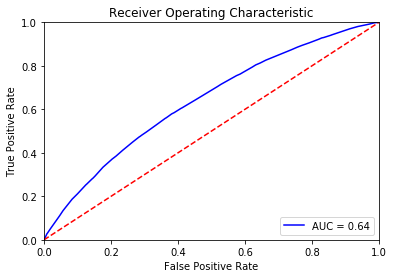

In [61]:
# plot roc_auc cure of decision tree model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def roc_auc_curve(y, preds):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

roc_auc_curve(y_test, y_pred_en)

### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, oob_score = True, random_state=0, n_jobs=-1,
                                max_features = "auto", min_samples_leaf = 50)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

#### Score the random forest model and plot roc curve

AUC - ROC :  0.685429370428


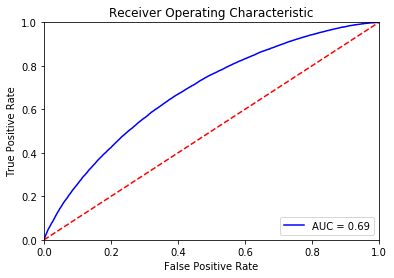

In [63]:
y_pred_rf = pd.DataFrame(forest.predict_proba(X_test)).iloc[:,1]
print("AUC - ROC : ", roc_auc_score(y_test, y_pred_rf))
roc_auc_curve(y_test, y_pred_rf)

Decision tree model's auc_roc score is 0.637 and random forest model get the score 0.685.

### Gradient Boosting Method

In [64]:
from sklearn.ensemble import GradientBoostingClassifier #For Classification

#### Tuning the learning rate 

In [68]:
learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
append = []
for i in learning_rate:
    clf = GradientBoostingClassifier(learning_rate=i)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=4)
    estimator = append.append(scores)
    print('learning rate ' + str(i) + ' mean scores: ' + str(scores.mean()))

learning rate 0.0001 mean scores: 0.856691087231
learning rate 0.001 mean scores: 0.856691087231
learning rate 0.005 mean scores: 0.856691087231
learning rate 0.01 mean scores: 0.856691087231
learning rate 0.05 mean scores: 0.856885026801
learning rate 0.1 mean scores: 0.85705917701


Learning rate decides the number of trees. The lower the learning rate the more of trees needed. Learning rate 0.1 performs better than other smaller rates.

#### Training and scoring the model

In [65]:
#try learning rate 0.1, 0.2, 0.3 and 0.5 and 0.2 is the best one
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=2)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

AUC - ROC :  0.695164170634


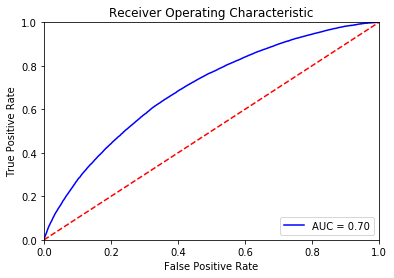

In [66]:
y_pred_gb = pd.DataFrame(clf.predict_proba(X_test)).iloc[:,1]
print("AUC - ROC : ", roc_auc_score(y_test, y_pred_gb))
roc_auc_curve(y_test, y_pred_gb)

GBM model gets a score of 0.695 and a little bit improvment than Random Forest 0.685.

To predict the loan status we tried Decision Tree, Random Forest and Gradient Boost method. We tuned hyperparameters and used cross validation. Finally we increase the ROC_AUC score from 0.637 to 0.695. Gradient Boost method proved to be the best method for the predictive model. 

## Comparing feature importance in the tree based methods

In [67]:
# Define top 10 important features function for printing and plot
features = df4.columns
def top_10_features(classifier):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
   
    #plot top 20 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Print the feature ranking top 20
    print("Top 10 feature ranking:")

    for f in range(len(indices)):
        print("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importances[indices[f]]))
    return importances, indices

#### Top 10 important features from Decision tree model

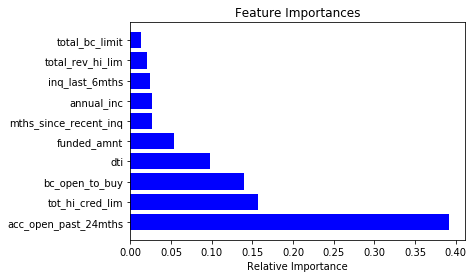

Top 10 feature ranking:
 1) acc_open_past_24mths           0.391798
 2) tot_hi_cred_lim                0.156528
 3) bc_open_to_buy                 0.139130
 4) dti                            0.098290
 5) funded_amnt                    0.053754
 6) mths_since_recent_inq          0.026543
 7) annual_inc                     0.026049
 8) inq_last_6mths                 0.023597
 9) total_rev_hi_lim               0.020172
10) total_bc_limit                 0.013095


In [70]:
D_importance, D_indice = top_10_features(clf_entropy)

#### Top 10 important features from Random forest model

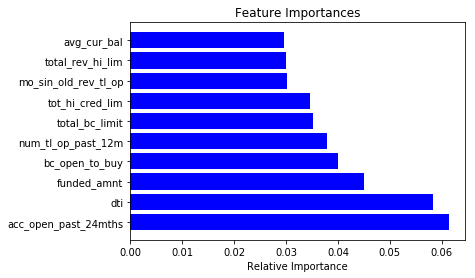

Top 10 feature ranking:
 1) acc_open_past_24mths           0.061432
 2) dti                            0.058367
 3) funded_amnt                    0.044979
 4) bc_open_to_buy                 0.040004
 5) num_tl_op_past_12m             0.037900
 6) total_bc_limit                 0.035266
 7) tot_hi_cred_lim                0.034621
 8) mo_sin_old_rev_tl_op           0.030147
 9) total_rev_hi_lim               0.030045
10) avg_cur_bal                    0.029514


In [72]:
F_importance, F_indice =top_10_features(forest)

#### Top 10 important features from Gradient boost model

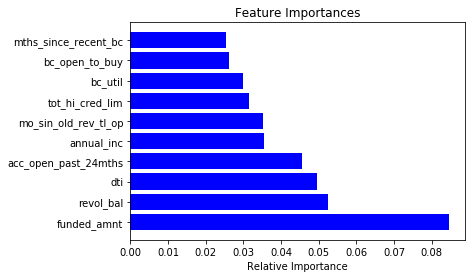

Top 10 feature ranking:
 1) funded_amnt                    0.084644
 2) revol_bal                      0.052458
 3) dti                            0.049636
 4) acc_open_past_24mths           0.045603
 5) annual_inc                     0.035486
 6) mo_sin_old_rev_tl_op           0.035171
 7) tot_hi_cred_lim                0.031488
 8) bc_util                        0.029816
 9) bc_open_to_buy                 0.026288
10) mths_since_recent_bc           0.025307


In [73]:
G_importance, G_indice =top_10_features(clf)

#### Let's get  three models' top ten important features

In [74]:
# the list of top ten important features
decision_tree =[]
for f in range(len(D_indice)):
    decision_tree.append(features[D_indice[f]])
    
forest =[]
for f in range(len(F_indice)):
    forest.append(features[F_indice[f]])

gbm =[]
for f in range(len(G_indice)):
    gbm.append(features[G_indice[f]])

In [76]:
top_10_features = pd.DataFrame({'decision_tree': decision_tree,
                                'forest': forest,
                                'gbm': gbm})

In [77]:
#print out top ten important features of the three models
top_10_features

,decision_tree,forest,gbm
0,acc_open_past_24mths,acc_open_past_24mths,funded_amnt
1,tot_hi_cred_lim,dti,revol_bal
2,bc_open_to_buy,funded_amnt,dti
3,dti,bc_open_to_buy,acc_open_past_24mths
4,funded_amnt,num_tl_op_past_12m,annual_inc
5,mths_since_recent_inq,total_bc_limit,mo_sin_old_rev_tl_op
6,annual_inc,tot_hi_cred_lim,tot_hi_cred_lim
7,inq_last_6mths,mo_sin_old_rev_tl_op,bc_util
8,total_rev_hi_lim,total_rev_hi_lim,bc_open_to_buy
9,total_bc_limit,avg_cur_bal,mths_since_recent_bc


In [79]:
# get the common important features of the three models
set(decision_tree).intersection(forest, gbm)

{'acc_open_past_24mths',
 'bc_open_to_buy',
 'dti',
 'funded_amnt',
 'tot_hi_cred_lim'}

Among the five common important features of the three models 'acc_open_past_24mths','bc_open_to_buy' and 'dti' are variables reflect the bank account information of the lenders. 'tot_hi_cred_lim' shows the credit information and 'funded_amnt' is the total amount committed to that loan at that point in time. Another common important feature is 'annual_inc' which is in both decision tree model and GBM. And it ranks 11 in random forest model

##### Summary of types of important features:
Decision tree: 

4 bank variabls: acc_open_past_24mths, bc_open_to_buy, dti, inq_last_6mths     
4 credit variables: tot_hi_cred_lim  mths_since_recent_inq  total_rev_hi_lim total_bc_limit     
1:  funded_amnt
1:  annual_inc  

Random Forest:

6 bank variables: acc_open_past_24mths, bc_open_to_buy, dti, num_tl_op_past_12m,
                  mo_sin_old_rev_tl_op  , avg_cur_bal  
                  
3 credit varaibles: tot_hi_cred_lim  total_bc_limit  total_rev_hi_lim                  
1:  funded_amnt

Gradient boost method:

6 bank variables: acc_open_past_24mths, bc_open_to_buy , dti , mo_sin_old_rev_tl_op,
                  mths_since_recent_, bc_util                        
                  
2 credit variables: revol_bal , tot_hi_cred_lim                    
1:  funded_amnt
1:  annual_inc  

### Build a model without 'Rate' variable

In [80]:
# Drop 'Rate' variable
df5 = df4.drop('Rate', axis=1)

#Fit the missing values with mean
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(df5)
imputed_data = imputer.transform(df5.values)

In [81]:
X1 = imputed_data
X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.4, random_state = 0)
print(X1_train.shape)
print(X1_test.shape)
print(y_train.shape)
print(y_test.shape)

(252657, 111)
(168438, 111)
(252657,)
(168438,)


AUC - ROC :  0.69487128738


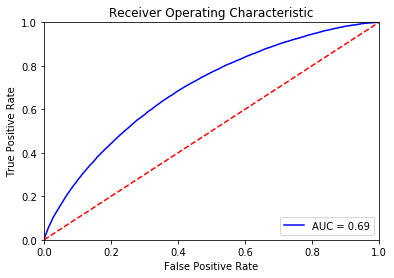

In [83]:
# fit the data with Gradient boost model we built befor
clf.fit(X1_train, y_train)
y_pred_gb = pd.DataFrame(clf.predict_proba(X1_test)).iloc[:,1]
print("AUC - ROC : ", roc_auc_score(y_test, y_pred_gb))
roc_auc_curve(y_test, y_pred_gb)

The accuracy of GBM model without 'Rate' Variable is 0.6948 and that of model with 'Rate' is 0.6952. There is a little change for the model accuracy with or without 'Rate' variable. The reason may be that original unemployment rate we get is by counties not zip codes. One county has several corresponding zip codes. If we use census data in U.S and recalculate the unemployment rate by zip code the 'Rate' variable may have more weight in the model.

There is still room for the improvement of model performance, however. In the EDA and statistical part we analyzed four features which are employment length, unemployment rate, employment title and home ownership. They all have impacts on the bad loan ratio and statistical testing shows the impacts have statistical significance. But from the feather importance analysis none of them is among the top ten important features. The employment title's importance is zero. It is worth to dig deeper for the feature "employment title". For example we can explore more than 10 employment titles and see if it will increase the importance of the feature. Or we can connect employment title with employment length and create a new variable, because the income for a teacher working for ten years will have great difference with a manager working for ten years. 

### Random Oversampling method in building predictive model

This data set has 80% good loan and 20% bad loan. It is imbalanced data set. Let's try SMOTE(Synthetic Minority Over-sampling) Technique in random oversampling method to balance the data set.

In [48]:
Y_train = y_train
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size = .1,
                                                  random_state=0)

In [49]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

C:\Users\yepeng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Fit the resampled date with gradient boost classifier

Oversampling is a well-known way to potentially improve models trained on imbalanced data. Advantages of oversampling is that unlike under sampling this method leads to no information loss and outperforms under sampling. But oversampling increases the likelihood of overfitting since it replicates the minority class events. Gradient boost method is great because the model architecture reduces overfitting.

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=2)
clf.fit(x_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

#### Check the accuracy and recall on validate data set and test data set

In [53]:
from sklearn.metrics import precision_score, recall_score
print('Validation Results')
print(clf.score(x_val, y_val))
print(recall_score(y_val, clf.predict(x_val)))
print('\nTest Results')
print(clf.score(X_test, y_test))
print(recall_score(y_test, clf.predict(X_test)))

Validation Results
0.85490382332
0.00682128240109

Test Results
0.856297272587
0.00734384025085


The model performance in validate set and test set are similiar. It shows we applied the random oversampling method correctly.

In [55]:
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred, average="macro"))

0.703983636072


The model performance of Gradient boost in imbalanced data set is 0.695 and that in balanced data set is 0.704. A little bit  improvement of model performance has been made by applying oversampling method to balance the data set. There are lots of methods to balance the imbalanced data set including Under_sampling, Over_sampling, Over-sampling followed by under-sampling and Ensemble sampling. It is worth trying other method to balance the data set and build models in the future work.